In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -qU python-gdcm pydicom pylibjpeg

In [3]:
import os
import cv2
import glob
import gdcm
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [4]:
train_images = glob.glob("/kaggle/input/rsna-breast-cancer-detection/train_images/*/*.dcm")
train = pd.read_csv("../input/rsna-breast-cancer-detection/train.csv")
test = pd.read_csv("../input/rsna-breast-cancer-detection/test.csv")

In [5]:
train

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [6]:
len(train_images)  # 54706

54706

# Removing labels and crop

In [7]:
def crop_image(img, show=True):
    # Binarize the image
    bin_pixels = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)[1]
   
    # Make contours around the binarized image, keep only the largest contour
    contours, _ = cv2.findContours(bin_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = max(contours, key=cv2.contourArea)

    # Create a mask from the largest contour
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)
   
    # Use bitwise_and to get masked part of the original image
    out = cv2.bitwise_and(img, mask)
    
    # get bounding box of contour
    y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
    x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])
    
    x1 = int(0.99 * x1)
    x2 = int(1.01 * x2)
    y1 = int(0.99 * y1)
    y2 = int(1.01 * y2)
    
    if show:
        plt.imshow(out[y1:y2, x1:x2], cmap="gray") ; 

    return out[y1:y2, x1:x2]

  0%|          | 0/10 [00:00<?, ?it/s]

patient 10706



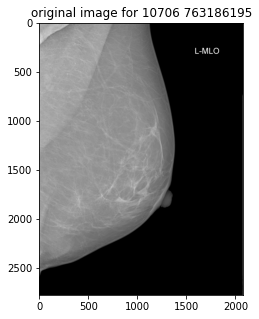

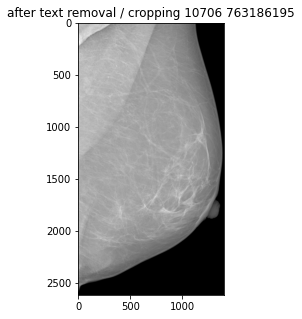

patient 10706



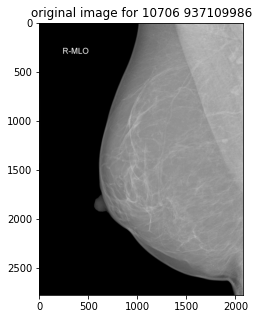

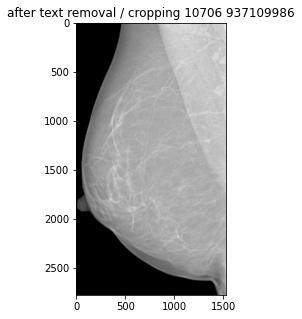

patient 10706



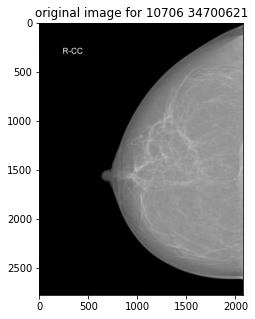

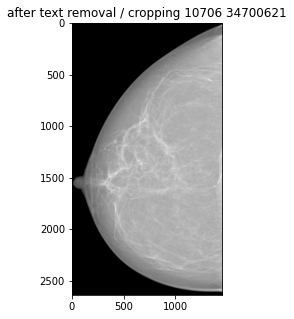

patient 10706



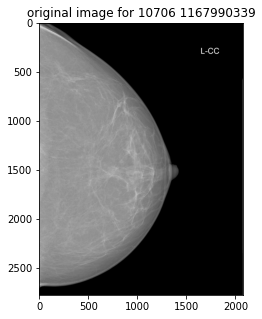

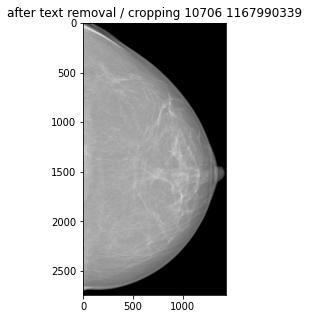

patient 21867



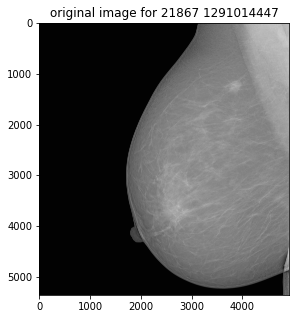

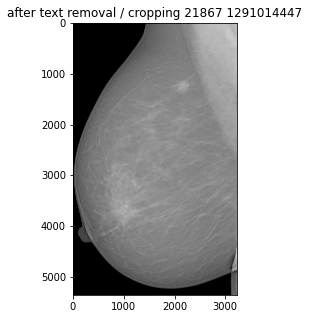

patient 21867



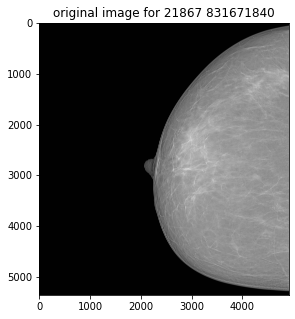

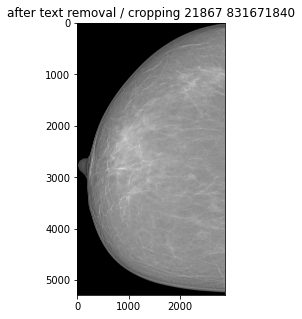

patient 21867



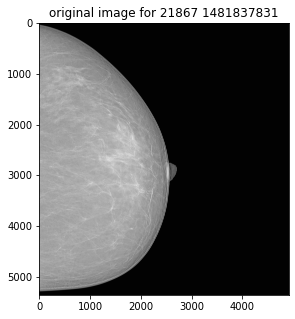

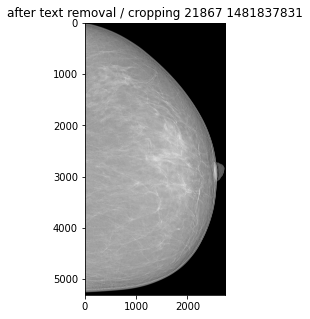

patient 21867



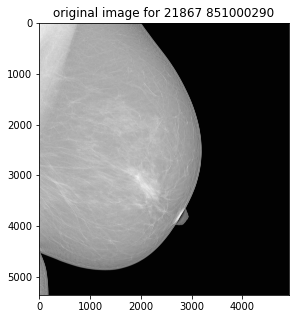

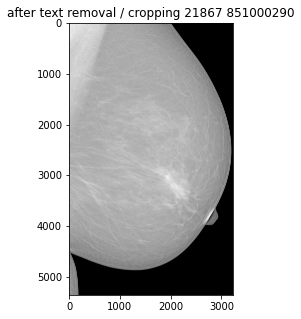

patient 34867



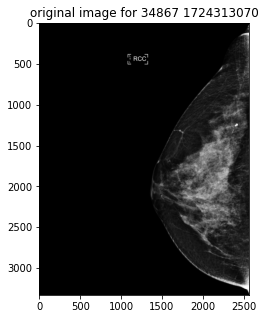

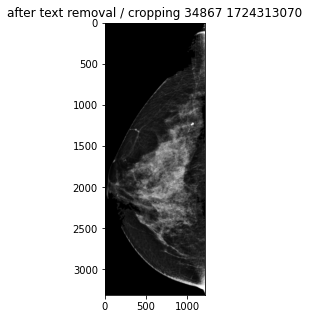

patient 34867



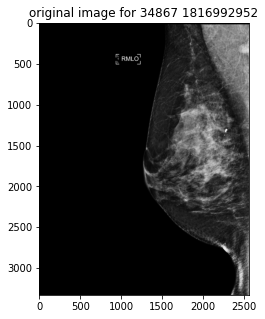

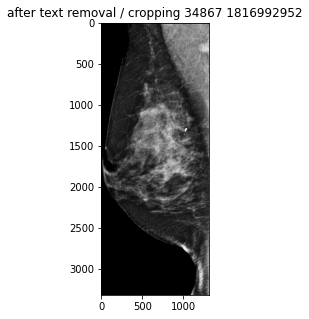

In [8]:
for f in tqdm(train_images[:10]):
    print(90*"=")
    patient = f.split('/')[-2]
    image = f.split('/')[-1][:-4]
    
    print(f"patient {patient}\n")
    
    dicom = pydicom.dcmread(f)
    img = dicom.pixel_array

    img = (img - img.min()) / (img.max() - img.min())    
    img *= 255
    img = np.uint8(img)

    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img

    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap="gray")
    plt.title(f"original image for {patient} {image}")
    plt.show()
        
    img = crop_image(img, show=False)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap="gray")
    plt.title(f"after text removal / cropping {patient} {image}")
    plt.show()
    
    crop_image(img, show=False)

# Converting DICOM to PNG

In [9]:
SAVE_FOLDER = "output/"
SIZE = 512
EXTENSION = "png"

os.makedirs(SAVE_FOLDER, exist_ok=True)

In [10]:
def process(f, size=512, save_folder="", extension="png"):
    patient = f.split('/')[-2]
    image = f.split('/')[-1][:-4]

    dicom = pydicom.dcmread(f)
    img = dicom.pixel_array

    img = (img - img.min()) / (img.max() - img.min())

    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img

    img = cv2.resize(img, (size, size))
    
# Python code to remove duplicate elements
def Remove(duplicate):
    final_list = []
    for num in duplicate:
        if num not in final_list:
            final_list.append(num)
            
    return cv2.imwrite(save_folder + f"{patient}_{image}.{extension}", (img * 255).astype(np.uint8))
     
# Driver Code
duplicate =patient
    

In [11]:
_ = Parallel(n_jobs=4)(
    delayed(process)(uid, size=SIZE, save_folder=SAVE_FOLDER, extension=EXTENSION)
    for uid in tqdm(train_images[:20])
)

  0%|          | 0/20 [00:00<?, ?it/s]

TypeError: Invalid shape (2,) for image data

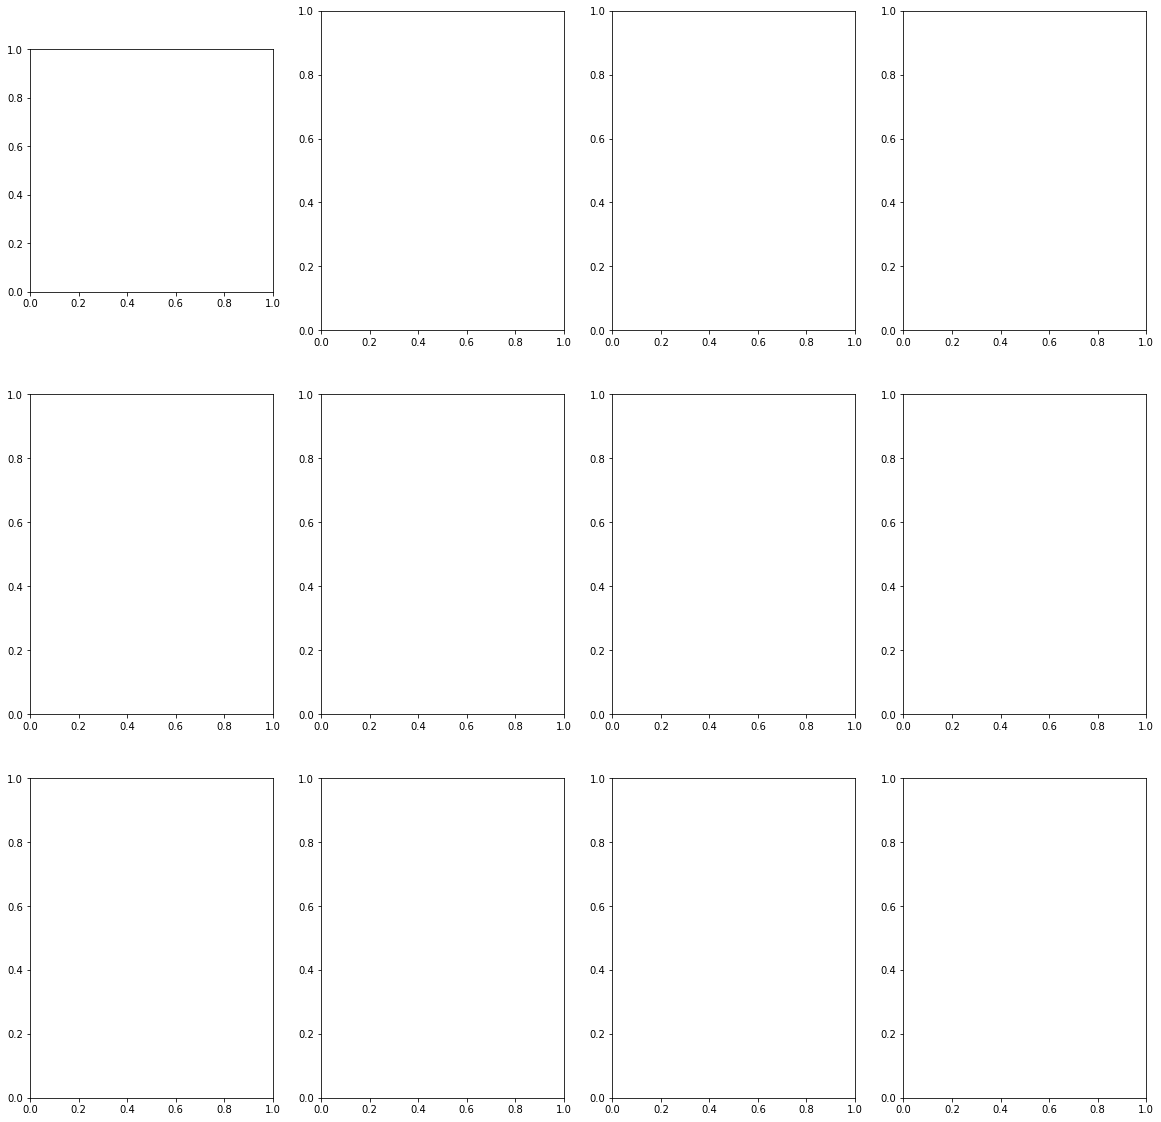

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 20))

sns.set_style('darkgrid')
sns.set_palette('Set2')

axs = axs.flatten()

count = 0
skip_count = 100
skip = False

for index, row in train[(train["laterality"] == "L") & (train["view"] == "MLO")].iterrows():
    if skip == 0:
        skip = 100
        _ = axs[count].imshow((row["patient_id"], row["image_id"]), cmap="bone")
        _ = axs[count].axis("off")
        _ = axs[count].set_title("View {} - Laterality {}".format(row["view"], row["laterality"]), fontsize=15)
        count += 1
        if count > 11:
            break
    else:
        skip -= 1